# Random Forest Model - Incorrect model analysis

In this notebook I have presented an example of unrealistic results caused by errors in model definition. Both returns and sharpe ratio were twice as large as the benchmark's. After in-depth analysis I have found 2 errors when allowing negative values in both loose contraints for target portfolios and also in predictions from random forest model.

In my investment algorithm portfolio weight should always match 1.0. However, with negative outputs, a portfolio could have sample weigths of 1.7 in long position and 0.7 in short position. When adding up weights 1.7 + (-0.7) = 1.0. Unfortunately, that would be equivalent of using extra funds in some periods and getting unfair advantage.

In this notebook, I am leaving original results, while source code have been fixed so that these results cannot be reproduced by rerunning notebook. Described in more details in chapter 4.11.

Input: single PCA component from 15 indicators for 6 months

Output: optimal max-shape portfolio with loose restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

import os
os.chdir(os.path.expanduser('../'))

from helper_functions import (calculate_returns_for_model, calculate_returns_for_predictions, calculate_metrics)

In [2]:
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators
days_to_recalculate = data_provider.get_days_to_recalculate()

In [4]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=9, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 9, 27)

In [5]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [6]:
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:test_split]
x_train = x[:test_split]
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = y[:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
x_test = x[test_split:]
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = y[test_split:]

## Training Model

In [7]:
regressor_random_forest = RandomForestRegressor(n_estimators=50,
                                                random_state=42)
regressor_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

## Backtesting

In [11]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [12]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [13]:
(total_ret, cum_total_ret) = calculate_returns_for_model(
    regressor_random_forest, x_test, dates_for_test, df_returns_test)

In [19]:
predictions = regressor_random_forest.predict(x_test)
predictions[predictions < 0] = 0

(total_ret_long_only, cum_total_ret_long_only) = calculate_returns_for_predictions(
    predictions, dates_for_test, df_returns_test)

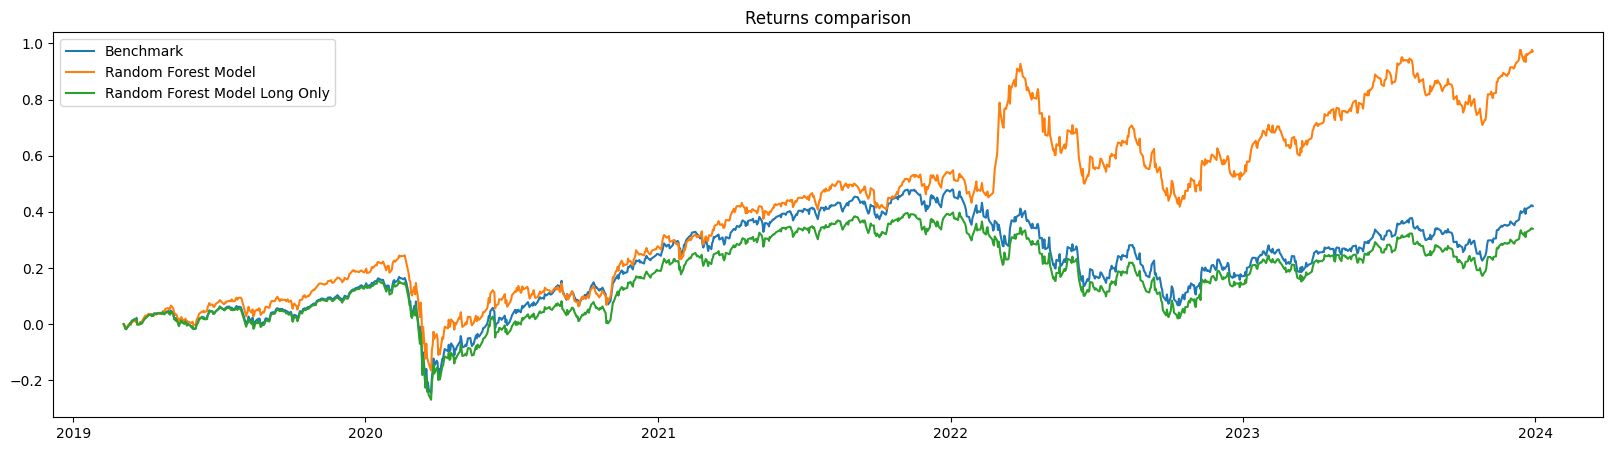

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_ret, label=f'Random Forest Model')
plt.plot(cum_total_ret_long_only, label=f'Random Forest Model Long Only')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [21]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret, df_results, f'Random Forest Model', benchmark_returns)
calculate_metrics(total_ret_long_only, df_results, f'Random Forest Model Long Only', benchmark_returns)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Random Forest Model,0.151278,0.210492,0.718691,0.888062,-0.329652,322.0,0.458904,0.802916
Random Forest Model Long Only,0.062645,0.201733,0.310535,0.359545,-0.367585,499.0,0.170423,-0.454134
